# How to read EnergiBridge Data

This Notebook contains a basic reference to the fields outputed by EnergiBridge.

EnnergiBridge is simply a wrapper to facilitate access to the Model-Specific Registers (MSR) that report energy consumption, and power usage information from NVIDIA libraries. Therefore, the output fields will depend on what information the CPU models provide.

I ran EnergiBridge for different CPUs and GPUs that I have access to. The following tables show the output fields for these architectures. These outputs should be consistent for different CPUs of the same vendor, but there might be some differences between models. For example, the 7900x does not have integrated graphics, while AMD laptop CPUs do, which might add additional fields. Double-check the CSV output when running Energibridge for the first time.

## EnergiBridge fields for AMD (Ryzen 7900X)

|        Label        | Meaning                                                                              |
|:-------------------:|--------------------------------------------------------------------------------------|
| Delta               | Difference in ms with respect to the previous data point                             |
| Time                | Unix timestamp in ms                                                                 |
| CPU_ENERGY (J)      | Monotonic counter of total CPU Energy usage                                          |
| COREX_ENERGY (J)    | Monotonic counter of total energy used by core X                                     |
| COREX_FREQ (MHZ)    | Frequency of core X                                                                  |
| COREX_PSTATE        | PSTATE of core X. See [these docs](https://docs.kernel.org/admin-guide/pm/amd-pstate.html)                                                                  |
| CORE0_VOLT (V)      | Voltage of core X                                                                    |
| CPU_USAGE_X         | Usage percentage of logical core X                                                   |
| TOTAL_MEMORY        | Total memory for the system (bytes)                                                  |
| USED_MEMORY         | Memory in use                                                                        |
| TOTAL_SWAP          | Total swap size                                                                      |
| USED_SWAP           | Swap in use                                                                          |

## EnergiBridge fields for Intel (i7-8750H)

|        Label        | Meaning                                                                              |
|:-------------------:|--------------------------------------------------------------------------------------|
| Delta               | Difference in ms with respect to the previous data point                             |
| Time                | Unix timestamp in ms                                                                 |
| CPU_FREQUENCY_X     | Frequency of core X                                                                  |
| CPU_USAGE_X         | Usage percentage of core X                                                           |
| DRAM_ENERGY (J)     | Monotonic counter of total energy used by RAM                                        |
| PACKAGE_ENERGY (J)  | Monotonic counter of total energy used by complete CPU + integrated graphics package |
| PP0_ENERGY (J)      | Monotonic counter of total energy used by entire CPU                                 |
| PP1_ENERGY (J)      | Monotonic counter of total energy used by integrated graphics                        |
| TOTAL_MEMORY        | Total memory for the system (bytes)                                                  |
| USED_MEMORY         | Memory in use                                                                        |
| TOTAL_SWAP          | Total swap size                                                                      |
| USED_SWAP           | Swap in use                                                                          |


## EnergiBridge fields for Apple M1
|        Label        | Meaning                                                                              |
|:-------------------:|--------------------------------------------------------------------------------------|
| Delta               | Difference in ms with respect to the previous data point                             |
| Time                | Unix timestamp in ms                                                                 |
| CPU_FREQUENCY_X     | Frequency of core X                                                                  |
| CPU_USAGE_X         | Usage percentage of core X                                                           |
| CPU_TEMP_X          | Core Temperature at the timestamp                                                    |
| SYSTEM_POWER (Watts)| Monotonic counter of total energy used by integrated graphics                        |
| TOTAL_MEMORY        | Total memory for the system (bytes)                                                  |
| USED_MEMORY         | Memory in use                                                                        |
| TOTAL_SWAP          | Total swap size                                                                      |
| USED_SWAP           | Swap in use                                                                          |

## Nvidia GPU output fields (GTX 1060)

|        Label        | Meaning                                                                              |
|:-------------------:|--------------------------------------------------------------------------------------|
| GPU0_POWER (mWatts) | GPU power at the given timestamp                                                     |
| GPU0_TEMPERATURE    | GPU temperature (Celsius)                                                            |
| GPU0_USAGE          | GPU usage percentage                                                                 |
| GPU0_MEMORY_TOTAL   | Total GPU memory (MB)                                                                |
| GPU0_MEMORY_USED    | Used GPU memory (MB)                                                                 |

## Basic EnergiBridge data reading

This notebook includes a couple of examples on how to read energy data from a EnergiBridge CSV. For the first examples, measurements are made in a Mac laptop. The second example ran on an AMD CPU.

Note that this is just a basic introduction. Project 1 will **require a much more in-depth analysis**: running multiple energy tests on the same workload, compute statistical metrics and run statistical tests, etc.

### Energy usage for computing Mandelbrot set

For the first example, we used EnergiBridge to measure the energy consumption of computing the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) for a certain region in space. We ran the computation using a single thread and all threads available in the CPU.

The data for these measurements is available in `data/mandelbrot`. The Rust code for it is available in `mandelbrot` if you want to try to run it yourself.

Since Mac only report instant power usage for each datapoint, we need to compute the total energy through integration ([trapezoid rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)).

In [26]:
# Open sequential.csv with pandas and compute total energy
import pandas as pd
import numpy as np
df_sequential = pd.read_csv("data/mandelbrot/sequential.csv")

# If data from Apple (column SYSTEM_POWER (Watts)), compute energy using trapezoidal rule
if "SYSTEM_POWER (Watts)" in df_sequential.columns:
    system_power_key = "SYSTEM_POWER (Watts)"
    system_energy = np.trapezoid(df_sequential[system_power_key], df_sequential['Time']/1000)
    print('Total system energy: {} J'.format(system_energy))

Total system energy: 5214.433344540076 J


In [27]:
df_parallel = pd.read_csv("data/mandelbrot/parallel.csv")

# If data from Apple (column SYSTEM_POWER (Watts)), compute energy using trapezoidal rule
if "SYSTEM_POWER (Watts)" in df_parallel.columns:
    system_power_key = "SYSTEM_POWER (Watts)"
    system_energy = np.trapezoid(df_parallel[system_power_key], df_parallel['Time']/1000)
    print('Total system energy: {} J'.format(system_energy))

Total system energy: 629.8189023677312 J


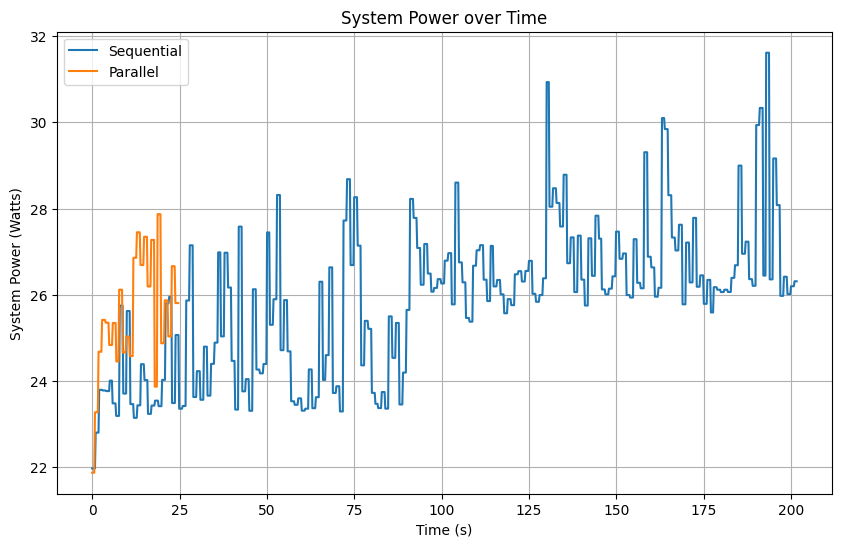

In [17]:
# Plot power over time for sequential and parallel runs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
if "SYSTEM_POWER (Watts)" in df_sequential.columns:
    # Set time to 0 at the start of the run
    df_sequential['Time'] = df_sequential['Time'] - df_sequential['Time'].iloc[0]
    plt.plot(df_sequential['Time']/1000, df_sequential[system_power_key], label='Sequential')
if "SYSTEM_POWER (Watts)" in df_parallel.columns:
    # Set time to 0 at the start of the run
    df_parallel['Time'] = df_parallel['Time'] - df_parallel['Time'].iloc[0]
    plt.plot(df_parallel['Time']/1000, df_parallel[system_power_key], label='Parallel')

plt.xlabel('Time (s)')
plt.ylabel('System Power (Watts)')
plt.title('System Power over Time')
plt.legend()
plt.grid()
plt.show()

### Energy usage of Redis Benchmark

The files in `data/redis`

In [28]:
df_alpine = pd.read_csv("data/redis/redis-alpine.csv")
df_ubuntu = pd.read_csv("data/redis/redis-ubuntu.csv")

In [29]:
# AMD reports energy as a monotonic counter for individual cores and whole cpu, rather than system power

energy_alpine = df_alpine['CORE0_ENERGY (J)'].iloc[-1] - df_alpine['CORE0_ENERGY (J)'].iloc[0]
print('Total energy for Alpine: {} J'.format(energy_alpine))
energy_ubuntu = df_ubuntu['CORE0_ENERGY (J)'].iloc[-1] - df_ubuntu['CORE0_ENERGY (J)'].iloc[0]
print('Total energy for Ubuntu: {} J'.format(energy_ubuntu))

Total energy for Alpine: 1594.9903564453125 J
Total energy for Ubuntu: 1410.6580200195312 J


In [30]:
# AMD reports energy as a monotonic counter for individual cores and whole cpu, rather than system power

energy_alpine = df_alpine['CPU_ENERGY (J)'].iloc[-1] - df_alpine['CPU_ENERGY (J)'].iloc[0]
print('Total energy for Alpine: {} J'.format(energy_alpine))
energy_ubuntu = df_ubuntu['CPU_ENERGY (J)'].iloc[-1] - df_ubuntu['CPU_ENERGY (J)'].iloc[0]
print('Total energy for Ubuntu: {} J'.format(energy_ubuntu))

Total energy for Alpine: 17841.164565980434 J
Total energy for Ubuntu: 15879.252792358398 J


### Exercise: Compute CPU Power and plot power usage across time

Recreate the plot from the first example, showing power usage across the execution. In this case, since AMD reports energy instead of power, you need to compute instant power between datapoints, based on the difference in energy and time.

In [40]:
key = 'CPU_ENERGY (J)'
#key = 'CORE0_ENERGY (J)'

# Add column for power in Watts by taking the difference of energy and dividing by the difference in time (convert to seconds)
df_alpine['CPU_POWER (W)'] = df_alpine[key].diff() / df_alpine['Time'].diff() * 1000
df_ubuntu['CPU_POWER (W)'] = df_ubuntu[key].diff() / df_ubuntu['Time'].diff() * 1000

# Reset time to start at 0
df_alpine['Time'] = df_alpine['Time'] - df_alpine['Time'].iloc[0]
df_ubuntu['Time'] = df_ubuntu['Time'] - df_ubuntu['Time'].iloc[0]


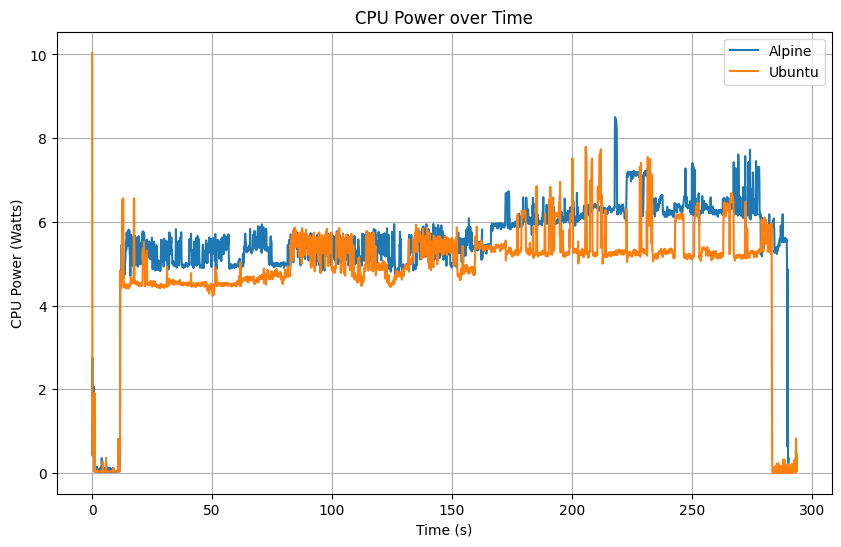

In [39]:
# Plot power
plt.figure(figsize=(10, 6))
plt.plot(df_alpine['Time']/1000, df_alpine['CPU_POWER (W)'], label='Alpine')
plt.plot(df_ubuntu['Time']/1000, df_ubuntu['CPU_POWER (W)'], label='Ubuntu')
plt.xlabel('Time (s)')
plt.ylabel('CPU Power (Watts)')
plt.title('CPU Power over Time')
plt.legend()
plt.grid()
plt.show()